In [1]:
# Import Required Libraries
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import numpy as np

In [2]:
# --- Data Loading and Initial Exploration ---

# Load dataset
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['Category', 'Message']]  # keep only label and message columns
df.columns = ['label', 'message']

print("First 5 rows of the dataset:")
print(df.head())

# Download stopwords if not already done
print("\nDownloading NLTK stopwords...")
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
print("Stopwords check complete.")

# Get the number of rows and columns
print(f"\nNumber of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Get data types
print("\nDataFrame Info:")
df.info()

# Checking Null values
print("\nNull values per column:")
print(df.isnull().sum())

# Checking Statistics
print("\nDataset Statistics:")
print(df.describe())

First 5 rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Stopwords check complete.

Number of rows: 5572
Number of columns: 2

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

Null values per column:
label      0
message    0
dtype: int64

Dataset Statistics:
       label                 message
count   5572                    5572
unique     2                    5157
top      ham  Sorry, I'll call later
fr

In [3]:
# --- Text Preprocessing ---

# Enhanced Function to clean text
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', ' _URL_ ', text) # Replace URLs with a token
    text = re.sub(r'\d+', ' _NUMBER_ ', text) # Replace numbers with a token
    text = re.sub(r'[^a-z_]', ' ', text)  # remove punctuation/special characters (keep underscore for tokens)
    tokens = text.split()  # tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # remove stopwords
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]  # stemming
    return " ".join(tokens)

# Apply cleaning
df['cleaned_message'] = df['message'].apply(clean_text)
print("\nOriginal vs Cleaned Messages (first 5 rows after enhanced cleaning):")
print(df[['message', 'cleaned_message']].head())


Original vs Cleaned Messages (first 5 rows after enhanced cleaning):
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri _ _ wkli comp win fa cup final tkt ...  
3                u dun say earli hor u c alreadi say  
4               nah think goe usf live around though  


In [4]:
# --- Feature Extraction ---

# TF-IDF with N-grams (unigrams and bigrams)
# This helps capture common phrases like "click here" or "free money"
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000) # Limiting features to 5000 for efficiency
X = tfidf_vectorizer.fit_transform(df['cleaned_message'])
y = df['label']

print("\nTF-IDF shape (with n-grams):", X.shape)


TF-IDF shape (with n-grams): (5572, 5000)


In [5]:
# --- Data Splitting and Resampling ---

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"\nOriginal training set shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training set shape: {X_resampled.shape}, {y_resampled.shape}")
print(f"Resampled class distribution: {pd.Series(y_resampled).value_counts()}")



Original training set shape: (4457, 5000), (4457,)
Resampled training set shape: (7718, 5000), (7718,)
Resampled class distribution: label
ham     3859
spam    3859
Name: count, dtype: int64


C:\Users\Thinkpad T480\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [6]:
# --- Model Training and Evaluation with Hyperparameter Tuning ---

# Create a custom scorer for F1-score of the 'spam' class
f1_spam_scorer = make_scorer(f1_score, pos_label='spam')

# Define models and their parameter grids for GridSearchCV
models_and_params = {
    "Naive Bayes": {
        'model': MultinomialNB(),
        'params': {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]} # Smoothing parameter
    },
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=1000, solver='liblinear'), # 'liblinear' is good for small datasets and L1/L2 penalties
        'params': {'C': [0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']} # Regularization strength and type
    },
    "SVM": {
        'model': LinearSVC(max_iter=2000, dual=False), # Added dual=False for sparse data and older sklearn versions
        'params': {'C': [0.1, 1.0, 10.0, 100.0]} # Regularization strength
    }
}

results = []
trained_models = {}
best_model_name = None
best_f1_score = -1

for name, mp in models_and_params.items():
    print(f"\nTraining and tuning {name}...")
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=f1_spam_scorer, n_jobs=-1, verbose=1)
    grid_search.fit(X_resampled, y_resampled)

    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label='spam')
    recall = recall_score(y_test, y_pred, pos_label='spam')
    f1 = f1_score(y_test, y_pred, pos_label='spam')

    print(f"\n{name} Results (Best Parameters: {grid_search.best_params_}):")
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    trained_models[name] = best_estimator # Store the best estimator

    # Track the best model based on F1-score for 'spam'
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = name

print(f"\nBest performing model based on F1-Score for 'spam': {best_model_name} (F1-Score: {best_f1_score:.4f})")



Training and tuning Naive Bayes...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Naive Bayes Results (Best Parameters: {'alpha': 0.1}):
Accuracy: 0.967713004484305
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       966
        spam       0.86      0.91      0.88       149

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Training and tuning Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Logistic Regression Results (Best Parameters: {'C': 100.0, 'penalty': 'l2'}):
Accuracy: 0.9802690582959641
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.94      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.95      0.96      1115
weighted 

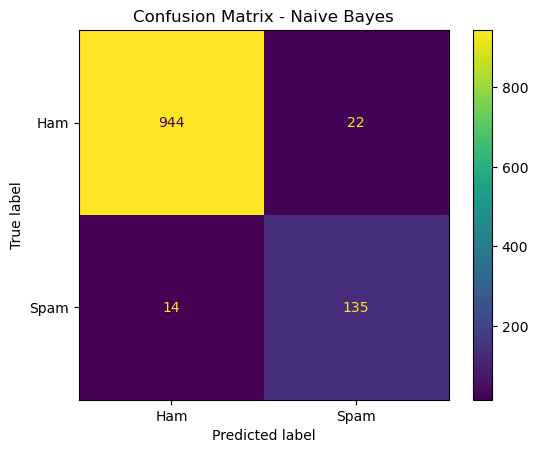

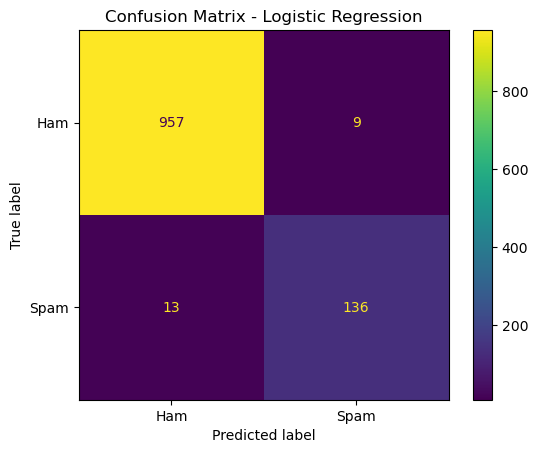

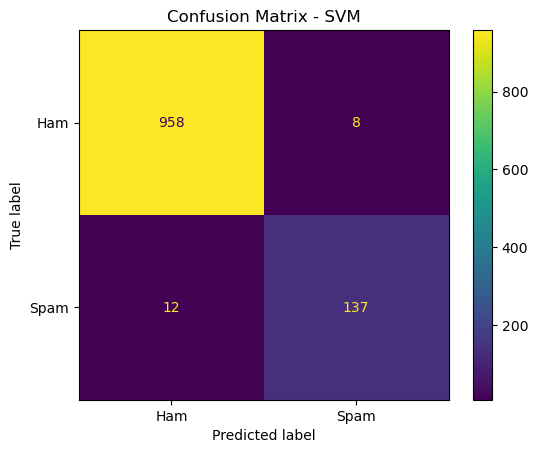


Model Comparison Table:


,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.967713,0.859873,0.906040,0.882353
1,Logistic Regression,0.980269,0.937931,0.912752,0.925170
2,SVM,0.982063,0.944828,0.919463,0.931973


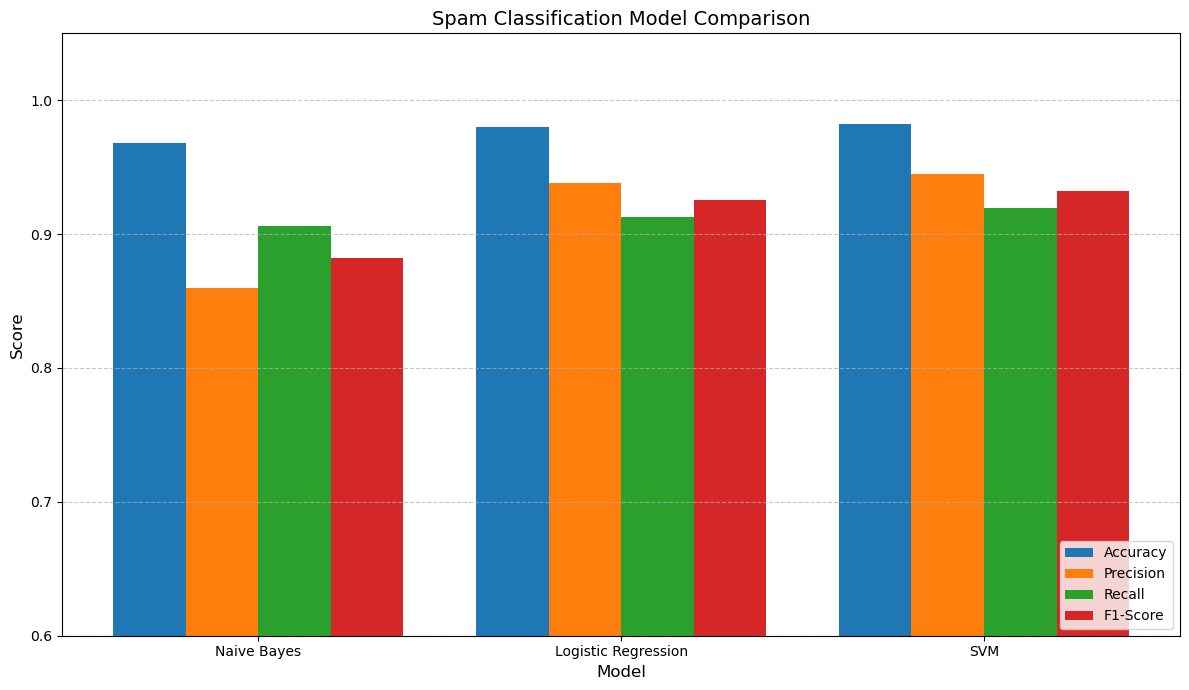

In [7]:
# --- Visualization ---

# Plot Confusion Matrix for each model
for name, model_obj in trained_models.items():
    y_pred = model_obj.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
    disp.plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Create comparison table
comparison = pd.DataFrame(results)
print("\nModel Comparison Table:")
display(comparison)

# Plotting comparison bar chart
models_for_plot = comparison['Model'].tolist()
accuracy_for_plot = comparison['Accuracy'].tolist()
precision_for_plot = comparison['Precision'].tolist()
recall_for_plot = comparison['Recall'].tolist()
f1_score_for_plot = comparison['F1-Score'].tolist()

bar_width = 0.2
x = np.arange(len(models_for_plot)) # Use numpy.arange for better bar positioning

plt.figure(figsize=(12, 7)) # Increased figure size
plt.bar(x - 1.5 * bar_width, accuracy_for_plot, width=bar_width, label='Accuracy')
plt.bar(x - 0.5 * bar_width, precision_for_plot, width=bar_width, label='Precision')
plt.bar(x + 0.5 * bar_width, recall_for_plot, width=bar_width, label='Recall')
plt.bar(x + 1.5 * bar_width, f1_score_for_plot, width=bar_width, label='F1-Score')

plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Spam Classification Model Comparison', fontsize=14)
plt.xticks(ticks=x, labels=models_for_plot, rotation=0, fontsize=10) # No rotation needed for 3 models
plt.ylim(0.6, 1.05)
plt.legend(loc='lower right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [9]:
# --- Model Saving ---

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

# Save each trained model
for name, model_obj in trained_models.items():
    filename = f"{name.lower().replace(' ', '_')}_model.joblib"
    joblib.dump(model_obj, filename)

print("\nModels and vectorizer saved successfully.")



Models and vectorizer saved successfully.


In [10]:
# --- Prediction on Custom Inputs ---

# Load the saved TF-IDF vectorizer and the best model for prediction
loaded_tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')
# Load the best model identified during training
loaded_best_model = joblib.load(f"{best_model_name.lower().replace(' ', '_')}_model.joblib")

custom_input = ["Free money!!! Click here now"]
cleaned_input = [clean_text(text) for text in custom_input]
custom_input_transformed = loaded_tfidf_vectorizer.transform(cleaned_input)

prediction = loaded_best_model.predict(custom_input_transformed)
print(f"\nPrediction for '{custom_input[0]}': {prediction[0]}")



Prediction for 'Free money!!! Click here now': spam
